# Load Packages

In [1]:

%load_ext autoreload
%autoreload 2

import sys
from os.path import join
from tqdm.auto import tqdm
import joblib
import torch
sys.path.append("../../")

from src.evaluation.consolidate import consolidate_pred_perf, consolidate_ue_perf, consolidate_pi_perf
from src.evaluation.perf_eval import display_pred_perf
from src.evaluation.ue_eval import display_ue_perf, restructure_ue_df
from src.evaluation.pi_eval import display_pi_perf, display_pi_perf_reorganised, reorganise_pi_table
from src.df_display.latex import df_to_latex, df_to_latex_grouped
from src.misc import create_folder
from ue_pi_dicts import pi_order
from src.df_display.heatmap import generate_pi_heatmap

seed_list=list(range(2023, 2023+5))
data_label = "mimic"
batch_size = 64

# File paths
fp_notebooks_folder = "../"
fp_project_folder = join(fp_notebooks_folder, "../")
fp_data_folder = join(fp_project_folder, "../", "data")
fp_output_data_folder = join(fp_data_folder, data_label)
fp_checkpoint_folder = join(fp_project_folder, "checkpoints")
fp_project_checkpoints = join(fp_checkpoint_folder, data_label)
fp_tuning = join(fp_project_checkpoints, "tuning")
fp_models = join(fp_project_checkpoints, "models")
fp_predictions = join(fp_project_checkpoints, "predictions")
fp_evaluation = join(fp_project_checkpoints, "model_evaluation")
fp_consolidated = join(fp_project_checkpoints, "consolidated_results")

2025-06-05 08:34:01.779858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-05 08:34:01.791909: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-05 08:34:01.795639: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-05 08:34:01.804849: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-05 08:34:02.419042: W tensorflow/compiler/tf2

# Prediction Performance

In [74]:
pred_perf_df = consolidate_pred_perf(seed_list, fp_evaluation)
display_pred_perf(pred_perf_df, consolidated=True)
pred_perf_df.to_csv(join(fp_consolidated, "pred_perf.csv"))

,t+1,t+2,t+3
Model,,,
RUE,0.0759 ± 0.001,0.1041 ± 0.001,0.1226 ± 0.001
MC Dropout,0.0764 ± 0.001,0.1051 ± 0.000,0.1235 ± 0.001
GPR,0.0716 ± 0.000,0.0993 ± 0.000,0.1177 ± 0.000
Infer-Noise,0.0759 ± 0.001,0.1041 ± 0.001,0.1226 ± 0.001
BNN,0.078 ± 0.000,0.1059 ± 0.000,0.1246 ± 0.001
DER,0.0762 ± 0.000,0.1051 ± 0.001,0.1217 ± 0.001


In [75]:
print(df_to_latex(pred_perf_df, column_format_dict={"t+1": "min", "t+2": "min", "t+3": "min"}))

\begin{tabular}{cccc}
 & \textbf{t+1} & \textbf{t+2} & \textbf{t+3} \\
Model &  &  &  \\
RUE & \underline{0.0759 ± 0.001} & \underline{0.1041 ± 0.001} & 0.1226 ± 0.001 \\
MC Dropout & 0.0764 ± 0.001 & 0.1051 ± 0.000 & 0.1235 ± 0.001 \\
GPR & \textbf{0.0716 ± 0.000} & \textbf{0.0993 ± 0.000} & \textbf{0.1177 ± 0.000} \\
Infer-Noise & \underline{0.0759 ± 0.001} & \underline{0.1041 ± 0.001} & 0.1226 ± 0.001 \\
BNN & 0.078 ± 0.000 & 0.1059 ± 0.000 & 0.1246 ± 0.001 \\
DER & 0.0762 ± 0.000 & 0.1051 ± 0.001 & \underline{0.1217 ± 0.001} \\
\end{tabular}



In [2]:
pred_perf_df = consolidate_pred_perf(seed_list, fp_evaluation, one_col=True)
display_pred_perf(pred_perf_df, consolidated=True)
# pred_perf_df.to_csv(join(fp_consolidated, "pred_perf.csv"))

,Aggregated
Model,
RUE,0.1008 ± 0.000
MC Dropout,0.1017 ± 0.000
GPR,0.0962 ± 0.000
Infer-Noise,0.1008 ± 0.000
BNN,0.1028 ± 0.000
DER,0.101 ± 0.000


In [3]:
print(df_to_latex(pred_perf_df, column_format_dict={"Aggregated": "min"}))

\begin{tabular}{cc}
 & \textbf{Aggregated} \\
Model &  \\
RUE & \underline{0.1008 ± 0.000} \\
MC Dropout & 0.1017 ± 0.000 \\
GPR & \textbf{0.0962 ± 0.000} \\
Infer-Noise & \underline{0.1008 ± 0.000} \\
BNN & 0.1028 ± 0.000 \\
DER & 0.101 ± 0.000 \\
\end{tabular}



# UE Performance

In [76]:
ue_perf_df = consolidate_ue_perf(seed_list, fp_evaluation, exclude_columns="Pval")
display_ue_perf(ue_perf_df, consolidated=True)

t+1


t+2


t+3


In [77]:
print(
    df_to_latex_grouped(
        ue_perf_df, 
        {"Corr": "max", "AURC":"min", "Sigma=0.1": "min", "Sigma=0.2": "min", "Sigma=0.3": "min", "Sigma=0.4": "min"})
)

\begin{tabular}{cccccccc}
\toprule
 &  & Corr & AURC & Sigma=0.1 & Sigma=0.2 & Sigma=0.3 & Sigma=0.4 \\
Time Horizon & Model &  &  &  &  &  &  \\
\midrule
\multirow[t]{6}{*}{t+1} & RUE & \textbf{0.431 ± 0.038} & 0.095 ± 0.003 & \underline{0.062 ± 0.007} & 0.079 ± 0.004 & 0.089 ± 0.005 & 0.095 ± 0.006 \\
 & MC Dropout & 0.192 ± 0.028 & 0.125 ± 0.001 & 0.103 ± 0.006 & 0.121 ± 0.002 & 0.129 ± 0.001 & 0.127 ± 0.001 \\
 & GPR & 0.205 ± 0.002 & \underline{0.084 ± 0.000} & 0.07 ± 0.003 & \underline{0.076 ± 0.000} & \underline{0.086 ± 0.001} & \underline{0.092 ± 0.001} \\
 & Infer-Noise & 0.086 ± 0.025 & 0.128 ± 0.002 & 0.124 ± 0.009 & 0.126 ± 0.005 & 0.13 ± 0.005 & 0.129 ± 0.003 \\
 & BNN & \underline{0.285 ± 0.017} & 0.116 ± 0.001 & 0.081 ± 0.004 & 0.104 ± 0.004 & 0.114 ± 0.002 & 0.118 ± 0.001 \\
 & DER & 0.242 ± 0.035 & \textbf{0.074 ± 0.002} & \textbf{0.057 ± 0.003} & \textbf{0.063 ± 0.002} & \textbf{0.071 ± 0.001} & \textbf{0.079 ± 0.001} \\
\cline{1-8}
\multirow[t]{6}{*}{t+2} & RUE & \te

# PI Performance

In [2]:
pi_perf_df = consolidate_pi_perf(
    seed_list, fp_evaluation, selected_columns=["CovP", "PINAW", "PINAFD", "CWFDC"],
    pi_order=pi_order
)
display_pi_perf(pi_perf_df, consolidated=True)
pi_perf_df.to_csv(join(fp_consolidated, "pi_perf.csv"))

t+1:


t+2:


t+3:


## Heatmap

/home/lirong/Projects/Prediction_Interval/code/notebooks/mimic/../../src/df_display/heatmap.py:209: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


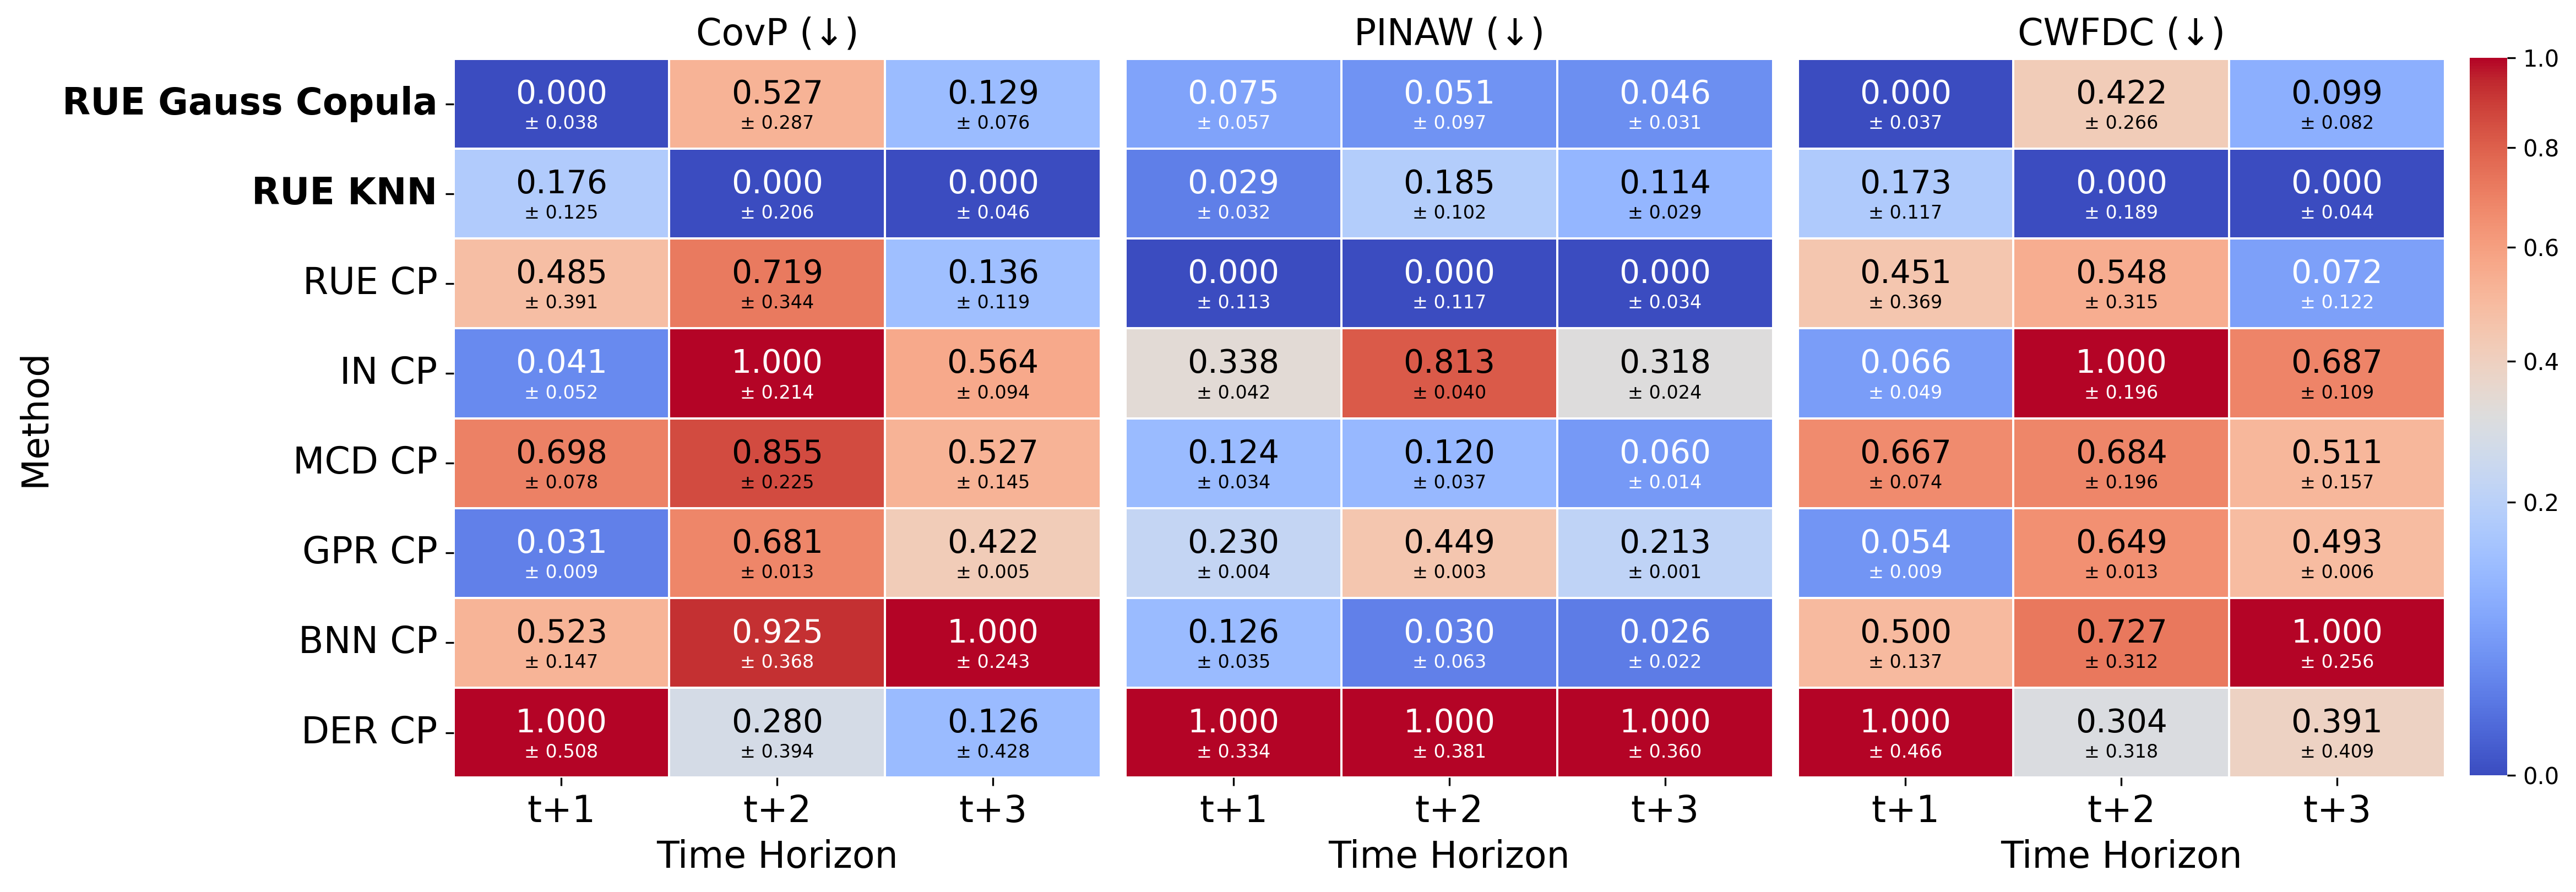

In [3]:
generate_pi_heatmap(
    seed_list, fp_evaluation=fp_evaluation, fp_consolidated=fp_consolidated, 
    bolded_methods=["RUE Gauss Copula", "RUE KNN"], pi_order=pi_order, gamma=0.6, save_fig=True,
    methods_to_drop=["RUE Cond Gauss", "RUE Weighted"],
    metrics=["CovP", "PINAW","CWFDC"], width=15, height=5.5
)

## Reorganised Table

In [4]:
pi_perf_df_reorganised = reorganise_pi_table(
    seed_list, fp_evaluation, pi_order, selected_columns=["CovP", "PINAW", "PINAFD", "CWFDC"],
)
pi_perf_df_reorganised = pi_perf_df_reorganised.drop(columns=[f"CWFDC\nt+{i+1}" for i in range(3)])
display_pi_perf_reorganised(pi_perf_df_reorganised)

,CovP t+1,CovP t+2,CovP t+3,CovP Avg,PINAW t+1,PINAW t+2,PINAW t+3,PINAW Avg,PINAFD t+1,PINAFD t+2,PINAFD t+3,PINAFD Avg,CWFDC Avg
RUE Gauss Copula,0.000207,0.000260,0.000220,0.000229,0.085629,0.108111,0.123988,0.105909,0.029922,0.044393,0.048007,0.040774,0.375759
RUE KNN,0.000289,0.000177,0.000181,0.000216,0.084049,0.112097,0.130470,0.108872,0.034070,0.047252,0.052633,0.044652,0.369304
RUE Cond Gauss,0.000574,0.000494,0.000376,0.000481,0.102751,0.126159,0.141565,0.123492,0.042036,0.052515,0.055747,0.050099,0.654693
RUE Weighted,0.001057,0.000324,0.000514,0.000632,0.072237,0.099924,0.107592,0.093251,0.026272,0.038291,0.041811,0.035458,0.760232
RUE CP,0.000434,0.000290,0.000222,0.000316,0.083063,0.106576,0.119560,0.103067,0.026880,0.038489,0.042608,0.035992,0.454615
IN CP,0.000227,0.000334,0.000353,0.000304,0.094642,0.130864,0.150164,0.125223,0.034022,0.051303,0.056924,0.047417,0.477079
MCD CP,0.000534,0.000311,0.000341,0.000396,0.087304,0.110166,0.125351,0.107607,0.028853,0.038035,0.042801,0.036563,0.539844
GPR CP,0.000222,0.000284,0.000309,0.000272,0.090931,0.119993,0.140064,0.116996,0.036687,0.049156,0.054946,0.046930,0.435670
BNN CP,0.000452,0.000322,0.000486,0.000420,0.087373,0.107485,0.122092,0.105650,0.028764,0.037350,0.041063,0.035726,0.561372
DER CP,0.000676,0.000221,0.000219,0.000372,0.117317,0.136457,0.215682,0.156485,0.021109,0.033486,0.040456,0.031684,0.560144


## Time-Method Table

In [5]:
print(
    df_to_latex_grouped(
        pi_perf_df, 
        {"PINAW":"min", "PINAFD": "min", "CovP":"min", "CWFDC":"min"})
)

\begin{tabular}{cccccc}
\toprule
 &  & CovP & PINAW & PINAFD & CWFDC \\
Time Horizon & Method &  &  &  &  \\
\midrule
\multirow[t]{10}{*}{t+1} & RUE Gauss Copula & \textbf{0.00021 ± 0.000} & 0.08563 ± 0.002 & 0.02992 ± 0.001 & \textbf{0.32271 ± 0.018} \\
 & RUE KNN & 0.00029 ± 0.000 & 0.08405 ± 0.001 & 0.03407 ± 0.001 & 0.4075 ± 0.057 \\
 & RUE Cond Gauss & 0.00057 ± 0.000 & 0.10275 ± 0.001 & 0.04204 ± 0.001 & 0.7183 ± 0.021 \\
 & RUE Weighted & 0.00106 ± 0.000 & \textbf{0.07224 ± 0.001} & \underline{0.02627 ± 0.001} & 1.15505 ± 0.405 \\
 & RUE CP & 0.00043 ± 0.000 & \underline{0.08306 ± 0.004} & 0.02688 ± 0.001 & 0.5443 ± 0.181 \\
 & IN CP & 0.00023 ± 0.000 & 0.09464 ± 0.001 & 0.03402 ± 0.000 & 0.35519 ± 0.024 \\
 & MCD CP & 0.00053 ± 0.000 & 0.0873 ± 0.001 & 0.02885 ± 0.000 & 0.65038 ± 0.036 \\
 & GPR CP & \underline{0.00022 ± 0.000} & 0.09093 ± 0.000 & 0.03669 ± 0.000 & \underline{0.34934 ± 0.004} \\
 & BNN CP & 0.00045 ± 0.000 & 0.08737 ± 0.001 & 0.02876 ± 0.001 & 0.56813 ± 0.067 \